In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.parse import stanford

import snowballstemmer
from nltk.corpus import stopwords


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd 
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from nltk.corpus import stopwords
from nltk import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
import string
import matplotlib.pyplot as plt;
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import pandas as pd
import matplotlib.cm as cm
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt, seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from wordcloud import WordCloud, STOPWORDS
from datetime import datetime
import datetime


In [6]:
raw_df= pd.read_csv('G:/Symbi/Dataset/TelecomPOC.csv')

In [7]:
raw_df.shape

(13, 7)

In [8]:
#Null values in Variables
raw_df.isnull().sum()

TweetID          0
Vertex1          0
Vertex2          0
Relationship1    0
Sentiment1       0
Relationship2    0
Tweet            0
dtype: int64

In [9]:
#DATA ONLY WITH Tweet Id, TEXT AND SENTIMENT
df = raw_df[['TweetID','Sentiment1','Tweet']].copy()

In [10]:
#SMAPLE

pd.set_option('display.max_colwidth', -1)
df.sample(5)

,TweetID,Sentiment1,Tweet
0,500200300400500000,Negative,@Vodafone won't not let me port to @JioCare for no reason. My second attempt and I don't know what to do. Agents are no good. The won't need to change to will not. And change couldn't and wouldn't
6,500200300400506,Negative,"@jiocare If you resolve the current issue, it shall let me recharge this other Jio number that I have"
5,500200300400505,Negative,@jiocare absolutely no response! Was that a mere consolation?
2,500200300400502,Negative,"@jiocare #jiofraud, no action in my complaint, my amount of recharge got wasted, return my money"
1,500200300400501,Negative,@jiocare Jio internet services depressing. Removal of digits 10 20 30


In [11]:
def clean_text(txt):
    
    """
    removing all hashtags , punctuations, stop_words  and links, also stemming words 
    """
    txt = txt.lower()
    def remove_stopwords(txt):
        return [t for t in txt if t not in stop]
    stop_words = set(stopwords.words("english"))
    txt = re.sub(r"won't","will not",txt) # to change won't with will not 
    txt = re.sub(r"(?<=\w)n't", " not",txt) #change n't to not 
    txt = re.sub(r"(@\w+)", "", txt)  # remove @sign. Generally twitter account
    txt = re.sub(r'\W', ' ', str(txt)) # remove all special characters including apastrophie 
    txt = txt.translate(str.maketrans('', '', string.punctuation)) # remove punctuations 
    txt = re.sub(r'\s+[a-zA-Z]\s+', ' ', txt)   # remove all single characters (it's -> it s then we need to remove s)
    txt = re.sub(r'\s+', ' ', txt, flags=re.I) # Substituting multiple spaces with single space
    txt = re.sub(r"(http\S+|http)", "", txt) # remove links 
    txt = ' '.join([PorterStemmer().stem(word=word) for word in txt.split(" ") if word not in stop_words ]) # stem & remove stop words
    txt = ''.join([i for i in txt if not i.isdigit()]).strip() # remove digits ()
    return txt

In [12]:
#APPLYING IT TO ALL 
df['cleaned_text'] = df['Tweet'].apply(clean_text)
print(clean_text(df['Tweet'][0]))
print(clean_text(df['Tweet'][1]))
print(clean_text(df['Tweet'][2]))
print(clean_text(df['Tweet'][3]))
print(clean_text(df['Tweet'][4]))

let port reason second attempt know agent good need chang chang could would
jio internet servic depress remov digit
jiofraud action complaint amount recharg got wast return money
recharg jio  plan show fail tri found got recharg twice tri call custom care end answer machin need refund
offici  day yet proper respons


In [13]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

In [14]:
df['tokenized'] = df['cleaned_text'].apply(lambda row: tokenize(row))

In [15]:
stop = set(stopwords.words('english'))
stop.update(['amp', 'rt', 'cc'])
stop = stop - set(['no', 'not'])

In [16]:
def remove_stopwords(row):
    return [t for t in row if t not in stop]

In [17]:
df['tokenized'] = df['tokenized'].apply(lambda row: remove_stopwords(row))

In [18]:
pd.set_option('display.max_colwidth', -1)

In [19]:
df[['Tweet', 'tokenized']].head()
df[['Tweet', 'tokenized']].tail()

,Tweet,tokenized
8,"When landsale value will be declared, the value will jump, at that time we should plan to sell","[landsal, valu, declar, valu, jump, time, plan, sell]"
9,@Mummy @papa results declared. GPA is 7.49. Max GPA is 10.0,"[result, declar, gpa, max, gpa]"
10,@Voda Sentiment and Topic classification and using results to interact with Twitter user,"[sentiment, topic, classif, use, result, interact, twitter, user]"
11,@Voda #Testing #Hashtag,"[test, hashtag]"
12,@amiriHadi #DataNotFound Wasted one day searching for your churn data. No luck. Pl. help,"[datanotfound, wast, one, day, search, churn, data, luck, pl, help]"


In [20]:
le = LabelEncoder()
df['target'] = le.fit_transform(df['Sentiment1'])

In [21]:
def train_test_data():   
    y = df['Sentiment1']   # define target and feature column
    X = df['cleaned_text']
    print(X)
        
    text_train, text_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=0)    # do the split
    vect = TfidfVectorizer(max_features=15, min_df=2, max_df=0.8, tokenizer=tokenize) # create Count vectorizer.
    X_train = vect.fit(text_train).transform(text_train) # transform text_train  into a vector 
    X_test = vect.transform(text_test) 
    feature_names = vect.get_feature_names() # to return all words used in vectorizer
  
    return X_train, X_test, y_train, y_test, feature_names

In [22]:
X_train, X_test, y_train, y_test, feature_names = train_test_data()
print(X_train.shape)
print(X_test.shape)
print(X_train)
print(feature_names)
print(' ')
print(X_test)

0     let port reason second attempt know agent good need chang chang could would                               
1     jio internet servic depress remov digit                                                                   
2     jiofraud action complaint amount recharg got wast return money                                            
3     recharg jio  plan show fail tri found got recharg twice tri call custom care end answer machin need refund
4     offici  day yet proper respons                                                                            
5     absolut respons mere consol                                                                               
6     resolv current issu shall let recharg jio number                                                          
7     ignor nazara last two year ebidta neg                                                                     
8     landsal valu declar valu jump time plan sell                                              

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

lgstc = LogisticRegressionCV(solver="newton-cg", multi_class='auto') 
lgstc.fit(X_train, y_train)

C:\Users\Tanisha Batra\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='newton-cg', tol=0.0001, verbose=0)

In [24]:
def print_model_performance(model,X_train,X_test,y_train,y_test):
    training_sample = model.predict(X_train)
    testing_sample = model.predict(X_test)
    print('training ')
    #print(classification_report(training_sample, y_train))  #uncomment if you want to see full report 
    print('train accuracy ',accuracy_score(training_sample, y_train))
    print('train precision_score ',precision_score(training_sample, y_train,average='micro')) 
    print('train recall score',recall_score(training_sample, y_train,average='micro')) 
    
    print('\n testing  ')
    print(classification_report(testing_sample, y_test))   #uncomment if you want to see full report 
    print('test average accuracy ',accuracy_score(testing_sample, y_test))
    print('test average precision_score ',precision_score(testing_sample, y_test,average='micro')) 
    print('test average recall score',recall_score(testing_sample, y_test,average='micro')) 
    print('test AUC ',roc_auc_score(testing_sample, y_test,average='micro'))
    
    print(confusion_matrix(testing_sample, y_test))

In [25]:
#TFIDF 
print_model_performance(lgstc, X_train, X_test, y_train, y_test)

training 
train accuracy  1.0
train precision_score  1.0
train recall score 1.0

 testing  
              precision    recall  f1-score   support

    Negative       1.00      0.50      0.67         2
     Neutral       0.00      0.00      0.00         0

    accuracy                           0.50         2
   macro avg       0.50      0.25      0.33         2
weighted avg       1.00      0.50      0.67         2

test average accuracy  0.5
test average precision_score  0.5
test average recall score 0.5


C:\Users\Tanisha Batra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [ ]:
y_true=y_test
y_pred=lgstc.predict(X_test)
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_true, y_pred)

In [26]:
class_names = np.array(['Negative', 'Neutral', 'Positive'])

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[1 0 0]
 [1 0 0]
 [0 0 0]]


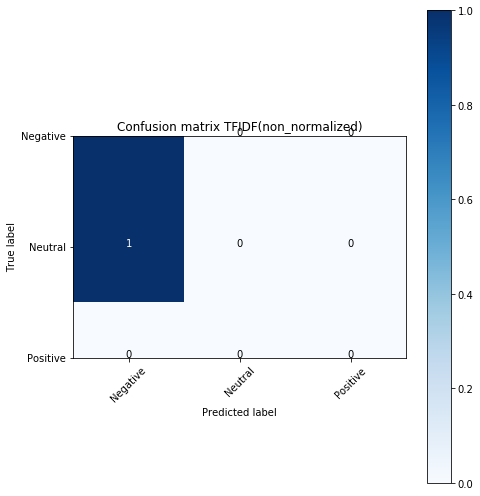

In [28]:
#TFIDF 
cnf_matrix = confusion_matrix(y_test, lgstc.predict(X_test),labels=['Negative', 'Neutral', 'Positive'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#fig, ax = plt.subplots()
#ax.set_ylim(len(harvest)-0.5, -0.5)
plt.figure(figsize=(7,7))
#plt.figure()

plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Neutral', 'Positive'],
                      title='Confusion matrix TFIDF(non_normalized)')

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [30]:
#TFIDF
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(lgstc, X_test, y_test, n_classes=3, figsize=(16, 10))

IndexError: too many indices for array

In [31]:
#countvect 
print_model_performance(lgstc, X_train, X_test, y_train, y_test)

y_true=y_test
y_pred=lgstc.predict(X_test)
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_true, y_pred)

training 
train accuracy  1.0
train precision_score  1.0
train recall score 1.0

 testing  
              precision    recall  f1-score   support

    Negative       1.00      0.50      0.67         2
     Neutral       0.00      0.00      0.00         0

    accuracy                           0.50         2
   macro avg       0.50      0.25      0.33         2
weighted avg       1.00      0.50      0.67         2

test average accuracy  0.5
test average precision_score  0.5
test average recall score 0.5


C:\Users\Tanisha Batra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [32]:
def get_tokens_coefs(vocab, coefs, n):
    coef_df = pd.DataFrame({'vocab': vocab, 'coef':coefs.reshape(-1)})
    return coef_df.sort_values('coef', ascending=False).reset_index(drop=True)[:n]

In [33]:
def plot_tokens_coefs(df, ax, label):
    df.sort_values('coef').plot.barh(legend=False, ax=ax)
    ax.set_yticklabels(df['vocab'].values.tolist()[::-1])
    ax.set_title(label);

In [34]:
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
sns.set_style(style='white')

In [35]:
vocab = vect.get_feature_names()
n_coefs = 15

fig, axs = plt.subplots(1, 3, figsize=(15, 8))
fig.subplots_adjust(wspace=0.8)

for i, l in enumerate(['Negative', 'Neutral', 'Positive']):
    coef_df = get_tokens_coefs(vocab, m.coef_[i], n_coefs)
    plot_tokens_coefs(coef_df, axs[i], l)

    
fig.savefig('tokenabcdef.png', transparent=True)

NameError: name 'vect' is not defined